In [71]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, jit, vmap, value_and_grad
import optax

from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten, Relu, Tanh,LogSoftmax)
#from jax.experimental import optimizers
from jax.example_libraries import optimizers

In [74]:
# output values from 0 to maxval with iters steps
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [75]:
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=None
        self._gamma = gamma
    def step(self, x):
        if self._val is None:
            self._val = x
        else:
            self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val

In [76]:
# make sure that the dvision is stable
def _stable_division(a,b,epsilon=1e-7):
    b = jnp.where(jnp.absolute(b)> epsilon, b, jnp.full_like(b, fill_value=epsilon)*jnp.sign(b))
    return a/b

In [77]:

batch_size = 100

## 5. Simulation of time series

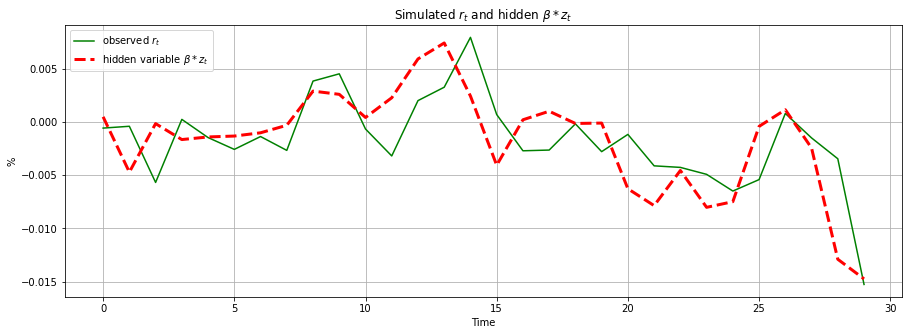

In [78]:
T = 30
#beta = 0.1694
beta=1
def make_time_series():
    
    
    phi = 0.99
    sigma_v = 0.003342
    sigma_u = 0.00328
    rho = -0.856
    cov_uv = rho * sigma_u * sigma_v

    # generating shocks
    mu = [0,0]
    cov = [[sigma_u**2, cov_uv], [cov_uv, sigma_v**2]]
    shocks = np.random.multivariate_normal(mu, cov, T)

    z0 = np.random.normal(0, sigma_u**2/(1-phi**2),1)
    r0 = shocks[0][0]

    z = np.zeros(T)
    r = np.zeros(T)
    z[0] = z0
    r[0] = r0

    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1][1]
        r[idx_t+1] = beta*z[idx_t+1] + shocks[idx_t+1][0]
    return z, r
z, r = make_time_series()
plt.figure(figsize=(15,5))
xvalues = np.array(range(T))
plt.plot(xvalues, r, linestyle='-', color='g', label="observed $r_t$")
plt.plot(xvalues, z, linestyle="--", color="r", label=r"hidden variable $\beta * z_t$", linewidth=3.0)

plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('%')
plt.grid(True)
plt.title(r"Simulated $r_t$ and hidden $\beta * z_t$")
plt.show()

In [79]:
@jit
def make_data():
    ts_ = jnp.linspace(0.1,30.0,30)
    ts_ext_ = jnp.array([0.] + list(ts_) + [30.1])
    ts_vis_ = jnp.linspace(0.1, 30.0, 300)
    ys_ = jnp.array(r[:,None])
    return ts_, ts_ext_, ts_vis_, ys_

In [80]:
ts, ts_ext, ts_vis, ys = make_data()

In [81]:
theta = 1.0
mu = 0.
sigma = 0.001
key = jrandom.PRNGKey(1)
logvar = jnp.log(sigma**2/(2.*theta))

py0_mean = jnp.array([[mu]])
py0_std = jnp.array([[sigma]])
qy0_mean = jnp.array([[mu]])
qy0_logvar = jnp.array([[logvar]])

init_net, net = stax.serial(Dense(200),Tanh,
                           Dense(200),Tanh,
                           Dense(1))
_,net_params = init_net(key,(batch_size,3))
params = [qy0_mean,qy0_logvar] + net_params




def get_std(logvar):
    return jnp.exp(.5 * logvar)

@jit
def loss(params,ys,key):
    zs, kl = forward(ts_ext,batch_size,params,key)
    zs = jnp.squeeze(zs)
    zs = zs[1:-1] 
    logpy = jax.scipy.stats.norm.logpdf(ys,loc=zs,scale=0.01).sum(axis=0).mean(axis=0)
    loss = -logpy + kl * kl_scheduler.val
    return loss

def forward(ts, batch_size,params,key):
    def f(t, y,args):
        t = jnp.full_like(y, t)
        return net(params[2:],jnp.concatenate((jnp.sin(t),jnp.cos(t),y),axis=-1))

    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma

    def h(t, y,args):  # Prior drift.
        return theta * (mu - y)

    def f_aug(t, y,args):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1] # 提取第一列，保持列的形态
        fv, gv, hv = f(t, y,args), g(t, y,args), h(t, y,args)
        u = _stable_division(fv - hv, gv) # 计算u(z,t)
        f_logqp = .5 * (u ** 2).sum(axis=1, keepdims=True) # 计算integral
        return jnp.concatenate([fv, f_logqp], axis=1)

    def g_aug(t, y,args):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        gv = g(t, y,args)
        g_logqp = jnp.zeros_like(y)
        return jnp.concatenate([gv, g_logqp], axis=1)
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    qy0_mean = params[0]
    qy0_std = get_std(params[1])
    eps_key,bm_key = jrandom.split(key,2)
    eps = jrandom.normal(key=eps_key,shape=(batch_size,1))
    y0 = qy0_mean + eps * qy0_std
    logqp0 = jnp.log(qy0_std/py0_std+(py0_std**2+(py0_mean-qy0_mean)**2)/(2*qy0_std**2)-0.5)
    logqp0 = logqp0.sum(axis=1)
    aug_y0 = jnp.concatenate([y0, jnp.zeros((batch_size,1))],axis=1)
        
    #control = diffrax.VirtualBrownianTree(t0=ts[0],t1=ts[-1],tol=0.5,shape=(),key=bm_key)
    #control = diffrax.UnsafeBrownianPath(shape=(),key=bm_key)
    control = diffrax.VirtualBrownianTree(t0=t0,t1=t1,tol=dt0/2,shape=(batch_size,2),key=bm_key)
    vf = diffrax.ODETerm(f_aug)
    cvf = diffrax.ControlTerm(g_aug, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=aug_y0,saveat=saveat)
    aug_ys = sol.ys
    ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
    logqp = (logqp0+logqp_path).mean()
    return ys, logqp
def sample_p(ts, batch_size,eps,control,key):
    
    
    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma

    def h(t, y,args):  # Prior drift.
        return theta * (mu - y)
    
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    y0 = py0_mean + eps * py0_std
    vf = diffrax.ODETerm(h)
    cvf = diffrax.ControlTerm(g, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y0,saveat=saveat,adjoint=diffrax.NoAdjoint())
    return sol.ys

def sample_q(ts, batch_size, params,eps,control,key):
    def f(t, y,args):
        t = jnp.full_like(y, t)
        return net(params[2:],jnp.concatenate((jnp.sin(t),jnp.cos(t),y),axis=-1))

    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    qy0_mean = params[0]
    qy0_std = get_std(params[1])
    y0 = qy0_mean + eps * qy0_std
    vf = diffrax.ODETerm(f)
    cvf = diffrax.ControlTerm(g, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y0,saveat=saveat,adjoint=diffrax.NoAdjoint())
    return sol.ys

In [82]:
@jit
def update(params, ys, opt_state,key):
    value, grads = value_and_grad(loss)(params,ys,key)
    opt_state = opt_update(0,grads, opt_state)
    return get_params(opt_state),opt_state, value

In [83]:
opt_init, opt_update, get_params = optimizers.adam(1e-2)
opt_state = opt_init(params)
kl_scheduler = LinearScheduler(iters=100)
    
logpy_metric = EMAMetric()
kl_metric = EMAMetric()
loss_metric = EMAMetric()

In [84]:
import torch.distributions
def main(opt_state,num_epochs = 500):
    
    p_key,eps_key, bm_key,per_key,k1 = jrandom.split(key,5)
    vis_batch_size = 1024
    ylims = (-0.03, 0.03)
    
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = jrandom.permutation(key=per_key,x=vis_batch_size)
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
    eps = jrandom.normal(key=eps_key,shape=(vis_batch_size,1))
    control = diffrax.VirtualBrownianTree(t0=ts_vis[0],t1=ts_vis[-1],tol=1e-2/2,shape=(vis_batch_size,1),key=jrandom.PRNGKey(1))
    #control = diffrax.UnsafeBrownianPath(shape=(),key=bm_key)
    sigma = jnp.std(ys)
    params = get_params(opt_state)
    
    # plot prior
    zs = sample_p(ts_vis,batch_size,eps,control,p_key).squeeze()
    zs = jnp.sort(zs,axis=1)
    plt.subplot(frameon=False)
    for alpha, percentile in zip(alphas, percentiles):
        idx = int((1 - percentile) / 2. * vis_batch_size)
        zs_bot = zs[:, idx]
        zs_top = zs[:, -idx]
        
        plt.fill_between(ts_vis, zs_bot, zs_top, alpha=alpha, color=fill_color)

    
    plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
    plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
    plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
    plt.ylim(ylims)
    plt.xlabel('$t$')
    plt.ylabel('$Y_t$')
        
    plt.tight_layout()
    plt.legend()
    plt.savefig('./img_diffrax/prior.png', dpi=300)
    plt.close()
    
    # for loop
    for epoch in range(num_epochs):
        if (epoch+1) % 50 == 0:
            img_path = os.path.join("./img_diffrax/", f'global_step_{epoch+1}.png')
            zs = sample_q(ts_vis,batch_size,params,eps,control,p_key).squeeze()
            plt.plot(ts_vis, zs.mean(axis=1), color='r',label=r'mean of latent variables')
            plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
            plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')

            plt.tight_layout()
            plt.legend()
            plt.savefig(img_path, dpi=300)
            plt.close()
        start_time = time.time()
        params, opt_state, loss = update(params, ys, opt_state,k1)
        
        loss_metric.step(loss)
        kl_scheduler.step()
        epoch_time = time.time()-start_time
        print("Epoch {} | T: {:0.2f} | loss {:0.3f}".format(epoch+1,epoch_time,loss))
        



In [85]:
logging.getLogger().setLevel(logging.INFO)

main(opt_state)

Epoch 1 | T: 23.28 | loss 20095.412
Epoch 2 | T: 4.12 | loss 513151.125
Epoch 3 | T: 4.11 | loss 11414.690
Epoch 4 | T: 4.25 | loss 9851.259
Epoch 5 | T: 4.19 | loss 20502.445
Epoch 6 | T: 4.06 | loss 24545.152
Epoch 7 | T: 4.30 | loss 22711.410
Epoch 8 | T: 4.09 | loss 17814.635
Epoch 9 | T: 4.09 | loss 12260.160
Epoch 10 | T: 4.13 | loss 7543.348
Epoch 11 | T: 4.10 | loss 4334.395
Epoch 12 | T: 4.16 | loss 2714.378
Epoch 13 | T: 4.09 | loss 2394.063
Epoch 14 | T: 4.09 | loss 2887.528
Epoch 15 | T: 4.21 | loss 3666.538
Epoch 16 | T: 4.11 | loss 4302.443
Epoch 17 | T: 4.15 | loss 4560.409
Epoch 18 | T: 4.21 | loss 4409.786
Epoch 19 | T: 4.23 | loss 3962.441
Epoch 20 | T: 4.36 | loss 3385.646
Epoch 21 | T: 4.31 | loss 2829.485
Epoch 22 | T: 4.10 | loss 2385.762
Epoch 23 | T: 4.20 | loss 2078.449
Epoch 24 | T: 4.13 | loss 1877.629
Epoch 25 | T: 4.09 | loss 1726.119
Epoch 26 | T: 4.44 | loss 1567.941
Epoch 27 | T: 4.13 | loss 1369.766
Epoch 28 | T: 4.28 | loss 1129.509
Epoch 29 | T: 4.24 

Epoch 241 | T: 4.13 | loss 43.006
Epoch 242 | T: 4.08 | loss 42.534
Epoch 243 | T: 4.11 | loss 42.062
Epoch 244 | T: 4.29 | loss 41.591
Epoch 245 | T: 4.47 | loss 41.120
Epoch 246 | T: 4.07 | loss 40.650
Epoch 247 | T: 4.32 | loss 40.180
Epoch 248 | T: 4.21 | loss 39.710
Epoch 249 | T: 4.08 | loss 39.242
Epoch 250 | T: 4.30 | loss 38.773
Epoch 251 | T: 4.24 | loss 38.305
Epoch 252 | T: 4.09 | loss 37.838
Epoch 253 | T: 4.22 | loss 37.371
Epoch 254 | T: 4.14 | loss 36.905
Epoch 255 | T: 4.08 | loss 36.440
Epoch 256 | T: 4.16 | loss 35.974
Epoch 257 | T: 4.10 | loss 35.510
Epoch 258 | T: 4.13 | loss 35.045
Epoch 259 | T: 4.17 | loss 34.581
Epoch 260 | T: 4.10 | loss 34.119
Epoch 261 | T: 4.14 | loss 33.656
Epoch 262 | T: 4.07 | loss 33.193
Epoch 263 | T: 4.18 | loss 32.732
Epoch 264 | T: 4.12 | loss 32.270
Epoch 265 | T: 4.10 | loss 31.810
Epoch 266 | T: 4.11 | loss 31.349
Epoch 267 | T: 4.48 | loss 30.889
Epoch 268 | T: 4.21 | loss 30.430
Epoch 269 | T: 4.08 | loss 29.971
Epoch 270 | T:

Epoch 480 | T: 4.12 | loss -58.044
Epoch 481 | T: 4.10 | loss -58.421
Epoch 482 | T: 4.08 | loss -58.798
Epoch 483 | T: 4.14 | loss -59.174
Epoch 484 | T: 4.35 | loss -59.550
Epoch 485 | T: 4.12 | loss -59.926
Epoch 486 | T: 4.12 | loss -60.301
Epoch 487 | T: 4.11 | loss -60.675
Epoch 488 | T: 4.24 | loss -61.049
Epoch 489 | T: 4.16 | loss -61.422
Epoch 490 | T: 4.08 | loss -61.794
Epoch 491 | T: 4.09 | loss -62.166
Epoch 492 | T: 4.11 | loss -62.538
Epoch 493 | T: 4.12 | loss -62.909
Epoch 494 | T: 4.14 | loss -63.279
Epoch 495 | T: 4.12 | loss -63.649
Epoch 496 | T: 4.10 | loss -64.018
Epoch 497 | T: 4.24 | loss -64.386
Epoch 498 | T: 4.27 | loss -64.754
Epoch 499 | T: 4.13 | loss -65.121
Epoch 500 | T: 4.30 | loss -65.488
